# Введение в анализ данных
## НИУ ВШЭ, 2019-2020 учебный год

### Домашнее задание №4

Задание выполнил(а): Байкалова Дарья

### Общая информация

__Дата выдачи:__ 24.05.2020

__Дедлайн:__ 23:59 07.06.2020


### Оценивание и штрафы

Оценка за ДЗ вычисляется по следующей формуле:

$$
min(\text{points}, 19)  \times 10 / 19,
$$

где points — количество баллов за обязательную часть, которое вы набрали. Максимальное число баллов, которое можно получить за обязательную часть — 19, а максимальное число дополнительных баллов, которые пойдут в бонус — 1.

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 балл в день, но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/).

Инвайт для группы ИАД-4: zG1cIyT

Перед отправкой перезагрузите ноутбук и проверьте, что все ячейки могут быть последовательно выполнены. Ноутбук должен запускаться с использованием python 3.6+

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from scipy import stats

## Random Forest своими руками (4 балла)

Реализуйте алгоритм случайного леса. В соответствии с построением алгоритма, ваша реализация должна сочетать в себе метод бэггинга и метод случайных подмножеств. Также она должна работать для двух типов задач: как для задачи регрессии, так и для задачи классификации.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn`.*

In [2]:
class RandomForest:
    def __init__(self, n_estimators, max_depth, max_features='sqrt', task_type='regression'):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        max_features - maximum features for each split in DecisionTree from sklearn
        task_type - 'regression' or 'classification'
        """
        self.n = n_estimators
        self.depth = max_depth
        self.feat = max_features
        self.type = task_type
        
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (k, d)
        y_train - np.array of shape (k,)
        """
        self.trees = [] # тут буду хранить деревья
        for i in range(self.n): # для каждого дерева выбираю обучающую выборку бустингом (с повторением)
            ind = np.random.choice(len(X_train), len(X_train))
            X_new = X_train[ind]
            y_new = y_train[ind]
            
            if self.type == 'classification':
                treeDC = DecisionTreeClassifier(max_depth=self.depth, max_features=self.feat)
                treeDC.fit(X_new, y_new)
                self.trees.append(treeDC)
            elif self.type == 'regression':
                treeDR = DecisionTreeRegressor(max_depth=self.depth, max_features=self.feat)
                treeDR.fit(X_new, y_new)
                self.trees.append(treeDR)

            
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        
        y_pred = np.zeros((len(X_test), self.n))
        
        if self.type == 'classification':
            for i, treeDC in enumerate(self.trees):
                y_pred[:, i] = treeDC.predict(X_test)
            y_pred = stats.mode(y_pred, axis=1)[0]

        elif self.type == 'regression':
            for i, treeDR in enumerate(self.trees):
                y_pred[:, i] = treeDR.predict(X_test)
            y_pred = y_pred.mean(axis=1)
            

        return y_pred

Проверьте вашу реализацию на задаче регрессии. Подберите оптимальные гиперпараметры, чтобы получить MSE < 10.25 **(не меняйте параметры сида)**.

In [3]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [4]:
np.random.seed(19052019)

myrf = RandomForest(n_estimators=100, max_depth=8, max_features=0.33, task_type='regression')
myrf.fit(X_train, y_train)

In [5]:
y_pred = myrf.predict(X_test)
mean_squared_error(y_test, y_pred)

9.956147375812982

Проверьте вашу реализацию на задаче классификации. Подберите оптимальные гиперпараметры, чтобы получить accuracy > 0.83 **(не меняйте параметры сида)**.

In [6]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [7]:
np.random.seed(19052019)

myrf = RandomForest(n_estimators=800, max_depth=15, max_features='sqrt', task_type='classification')
myrf.fit(X_train, y_train)

In [8]:
y_pred = myrf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9440559440559441

## Градиентный бустинг своими руками (5 + 1* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Однако чтобы получить дополнительный 1 балл вам нужно реализовать нахождение оптимального $\gamma_N$ на каждом шаге.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [9]:
# это может помочь вам для поиска оптимальных gamma

from scipy.optimize import minimize

Проверьте вашу реализацию. Подберите оптимальные гиперпараметры, чтобы получить MSE < 10 как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**.

In [10]:
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [11]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n = n_estimators
        self.depth = max_depth
        self.lrate = learning_rate
        self.gamma_trees = []
        self.loss_train = []
        self.loss_test=[]
    
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (k, d)
        y_train - np.array of shape (k,)
        """
        self.X = X_train
        self.y = y_train
        pred = np.zeros(y_train.shape[0])
     
        
        for i in range(self.n):
            if i == 0:
                delta = y_train
            else:
                delta = (y_train - pred)
            tree = DecisionTreeRegressor(max_depth=self.depth)
            tree.fit(X_train, delta)
            
            
            def loss(gamma):
                return np.sum((y_train - (pred + gamma * tree.predict(X_train))) ** 2)
            
                        
            gamma = minimize(loss, 2.33).x
            self.gamma_trees.append((gamma, tree))
            pred += gamma * self.lrate * tree.predict(X_train)
            self.loss_train.append(mean_squared_error(y_train, pred + self.lrate * gamma * tree.predict(X_train))) 
                        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred=np.zeros(y_test.shape[0])
        for gamma, tree in self.gamma_trees:
            y_pred += self.lrate * gamma * tree.predict(X_test)
            self.loss_test.append(mean_squared_error(y_test,y_pred)) 
        return y_pred

In [12]:
np.random.seed(19052019)

mygbg = GradientBoosting(n_estimators=50, max_depth=6, learning_rate=0.2)
mygbg.fit(X_train, y_train)

In [13]:
y_pred = mygbg.predict(X_test)
mean_squared_error(y_test, y_pred)

9.68655649497412

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да 

## Ансамблевые методы (10 баллов)

Сопровождайте код изображениями и комментариями. Не игнорируйте вопросы, ваши выводы тоже оцениваются. Чем больше информации вы сможете извлечь, аргументированных выводов сформулировать, тем лучше. Не забывайте подписывать графики и будет вам счастье!

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

plt.style.use('seaborn-dark')
%matplotlib inline

**0. (0 баллов) ** Загрузите [датасет](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data), в нем вы найдете данные опрошенных женщин из индейского племени Пима. Будем решать задачу бинарной классификации: в колонке Outcome лежит метка наличия или отсутствия диабета - это наша целевая переменная. Есть ли пропущенные значения?

In [23]:
data = pd.read_csv('diabetes.csv')

In [24]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [25]:
data[data['Outcome'].isnull()]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


В колонке Outcome пропусков нет

**1. (0.5 балла)** Как вы думаете, является ли наличие нулей в некоторых колонках фактом того, что эти признаки имеют пропущенные значения? Замените нули на среднее значение признака там, где считаете это целесообразным.

In [26]:
# колонки, в которых есть нули
data.columns[data.apply(lambda col: 0 in col.unique())]

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'Outcome'],
      dtype='object')

   -  Нули в колонках 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI' указывают на пропуски, так как очевидно, что данные показатели не могут быть равны нулю у живого человека
   -  'Pregnancies' может быть любым целым числом, поэтому 0 не означает пропуск
   -  'Outcome' - бинарный признак, он принимает значения 0 или 1

In [27]:
# колонки, в которых более 20% пропусков
data.columns[data.apply(lambda col: data[col==0].shape[0] / data.shape[0] > 0.2)]

Index(['SkinThickness', 'Insulin', 'Outcome'], dtype='object')

Пусть наличие более 20% пропусков будет считаться существенным. Учитывая, что в 'Outcome' ноль не указывает на пропуск, я заменю нули средними значениями в колонках 'SkinThickness' и 'Insulin'

In [28]:
data.SkinThickness.replace([0], data['SkinThickness'].mean(), inplace=True) 
data.Insulin.replace([0], data['Insulin'].mean(), inplace=True) 

**2. (1 балл)** Визуализируйте распределение признаков по отдельности для больных диабетом и здоровых. Ваши графики должны быть примерно такими:

![Image](https://d.radikal.ru/d03/2005/f8/0ffb9443cbcf.png)

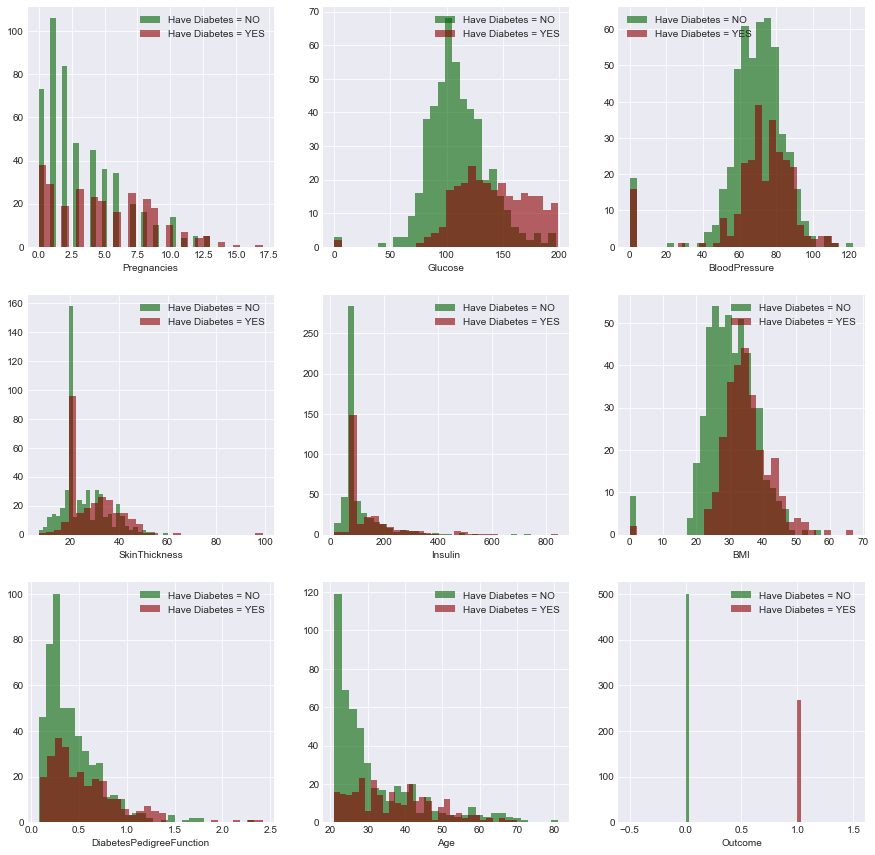

In [29]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

c = 0
for name in data.columns:
    i = c // 3
    j = c % 3
    ax[i][j].hist(data[data['Outcome']==0][name], bins=30, color='darkgreen', alpha=0.6, label='Have Diabetes = NO')
    ax[i][j].hist(data[data['Outcome']==1][name], bins=30, color='darkred', alpha=0.6, label='Have Diabetes = YES')
    ax[i][j].set_xlabel(name)
    c += 1
    ax[i][j].grid()
    ax[i][j].legend(loc='best')
                                    
    

plt.show()

**3. (2 балла)** Разбейте данные на обучающую и тестовую часть в соотношении 70:30. Обучите `BaggingClassifier` на деревьях (поставьте параметр `'base_estimator' = DecisionTreeClassifier()`) и `RandomForest`. Возьмите количество базовых алгоритмов, равное 10. Посчитайте accuracy, recall и precision. Есть ли какая-то разница между моделями и их результатами? Как вы думаете, почему получились такие результаты?

*Подсказка: создайте отдельную функцию для вывода метрик качества.*

In [30]:
import seaborn as sns
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [31]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [144]:
np.random.seed(3450)

X = data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']]
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

In [145]:
dt_clf = BaggingClassifier(
   base_estimator=DecisionTreeClassifier(), n_estimators=10 )
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

In [146]:
def metrics(y_test, y_pred):
    ac = '{:.2f}'.format(accuracy_score(y_test, y_pred))
    pr = '{:.2f}'.format(precision_score(y_test, y_pred))
    r = '{:.2f}'.format(recall_score(y_test, y_pred))
    return 'Accuracy = {}, Precision = {}, Recall =  {}'.format(ac,pr,r)

In [147]:
metrics(y_test, y_pred)

'Accuracy = 0.74, Precision = 0.70, Recall =  0.52'

In [148]:
rf_clf = RandomForestClassifier(n_estimators=10)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

In [149]:
metrics(y_test, y_pred)

'Accuracy = 0.76, Precision = 0.75, Recall =  0.54'

RandomForest и BaggingClassifier выдают примерно одинаковые метрики качества, но у RandomForest чуть больше. Основное отличие случайного леса от бэггинга в том, что опитмальное разбиение каждой вершины ищется из q случайных признаков (на каждой вершине разные), что уменьшает корреляцию между деревьями и улучшает модель. В данном случе признаков не так много (всего 8) и деревьев всего 10, что может снижать разницу в метриках качества. Также влияет то, что выборка относительно и при изменении random.seed метрики качества BaggingClassifier могут быть выше (разница в метриках качества не такая большая). Другими словами, конкретно с этой выборкой не так наглядно видно преимущество RandomForest, но по идее RandomForest должен выдавать метрики качества выше

**4. (2 балл)** Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров:
* `'n_estimators'` (можно перебрать около 10 значений из отрезка от 10 до 1500)
* `'min_samples_leaf'` (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Какие выводы вы можете сделать?

In [150]:
from sklearn.metrics import roc_auc_score

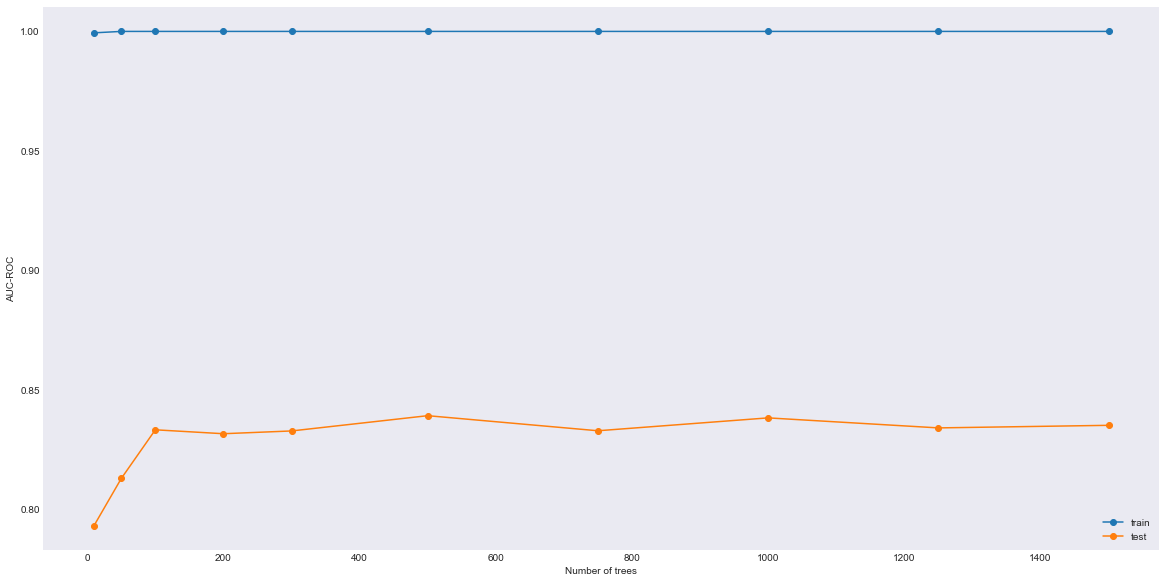

In [151]:
n_trees = [10, 50, 100, 200, 300, 500, 750, 1000, 1250, 1500]
quals_train = []
quals_test = []
for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(20, 10))
plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Кажется, можель переобучилась: на обучающей выборке все очень хорошо, на тестовой - хуже. Начиная с 200-от количество деревьев качество на тестовой почти не меняется. Это подтверждает тот факт, что RandomForest не переобучается при росте числа деревьев, поэтому он считается более универсальным методом.

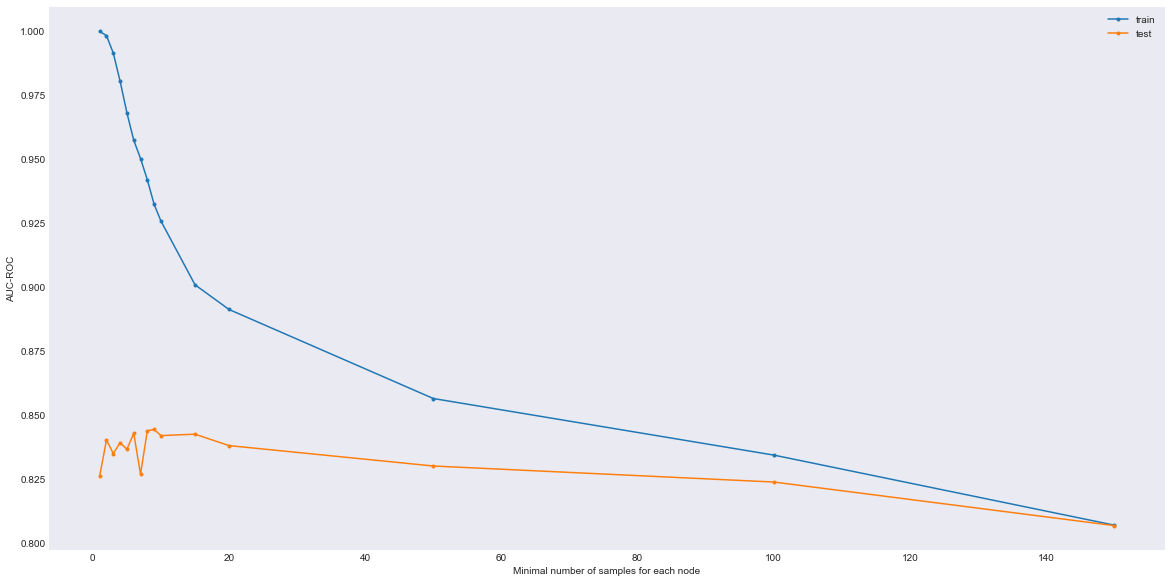

In [152]:
min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50, 100, 150]
quals_train = []
quals_test = []
for m in min_samples_leaf:
    rf = RandomForestClassifier(min_samples_leaf=m)
    rf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(20, 10))
plt.plot(min_samples_leaf, quals_train, marker='.', label='train')
plt.plot(min_samples_leaf, quals_test, marker='.', label='test')
plt.xlabel('Minimal number of samples for each node')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

С ростом min_samples_leaf качество стабильно падает на обучающей выборке. Судя по результатам на тестовой лучше брать min_samples_leaf примерно 15 (площадь под ROC кривой больше). То есть лучше брать не очень большое число.

**5. (1 балл)**. Посмотрите, оказались ли какие-то признаки более важными, чем остальные? Воспользуйтесь соответствующим атрибутом случайного леса в библиотеке `sklearn`, чтобы построить `barplot`.

In [153]:
features_importances = rf_clf.feature_importances_
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

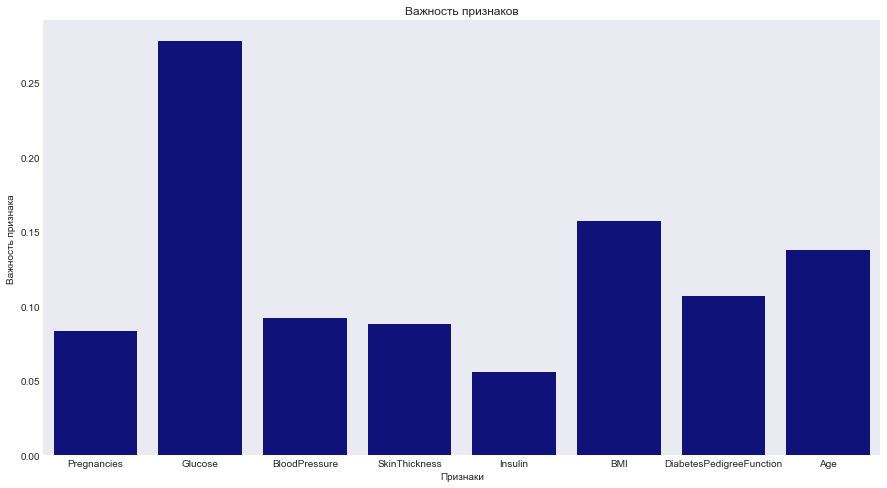

In [154]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(features, features_importances, color='darkblue')
labels = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
plt.title('Важность признаков')
plt.xlabel('Признаки')
plt.ylabel('Важность признака')

plt.show()

Самыми важными показателями оказались "Glucose", "DiabetesPedigreeFunction" и "BMI" (Body mass index).

**6. (2 балла)** Обучите `HistGradientBoostingClassifier` и `GradientBoostingClassifier` из `sklearn`. Опишите подробно, в чем заключается разница этих моделей. Подберите подходящее количество деревьев и проанализируйте метрики, с которыми мы работали выше.

HistGradientBoostingClassifier вместо перебора по всем значениям признака, как это происходит в случае GradientBoostingClassifier, перебор происходит по гистограмме этого признака (поэтому допускается наличие пропусков). Так как перебор происходит по меньшему количеству значений, HistGradientBoostingClassifier работает гораздо быстрее.


Нарисую графики AUC-ROC, чтобы подобрать оптимальное количество деревьев

In [155]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier

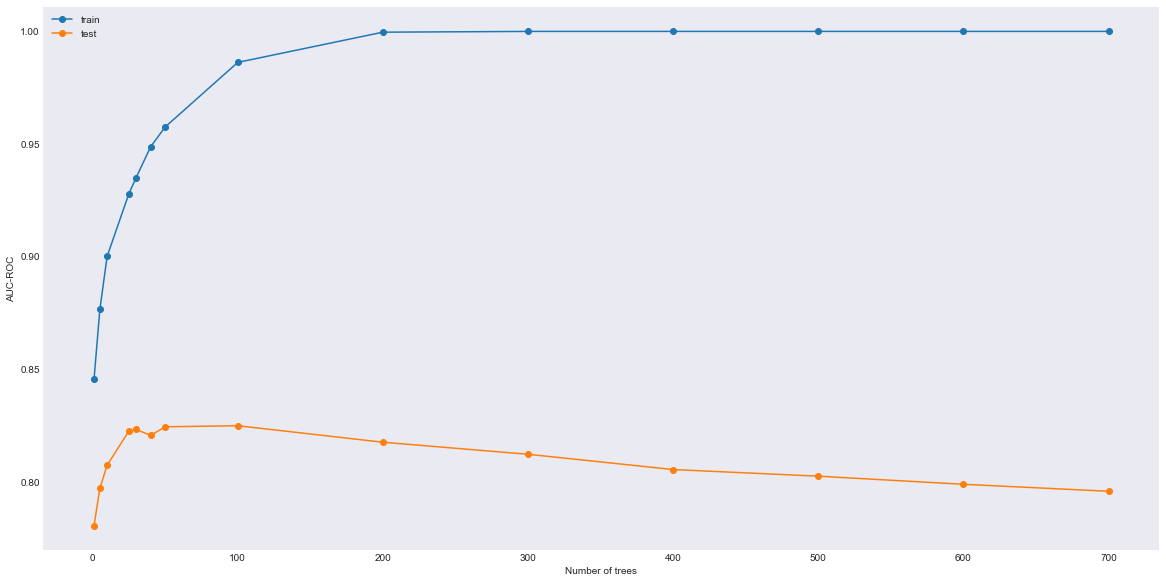

In [156]:
n_trees = [1, 5, 10, 25, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    gb = GradientBoostingClassifier(n_estimators=n)
    gb.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, gb.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(20, 10))
plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

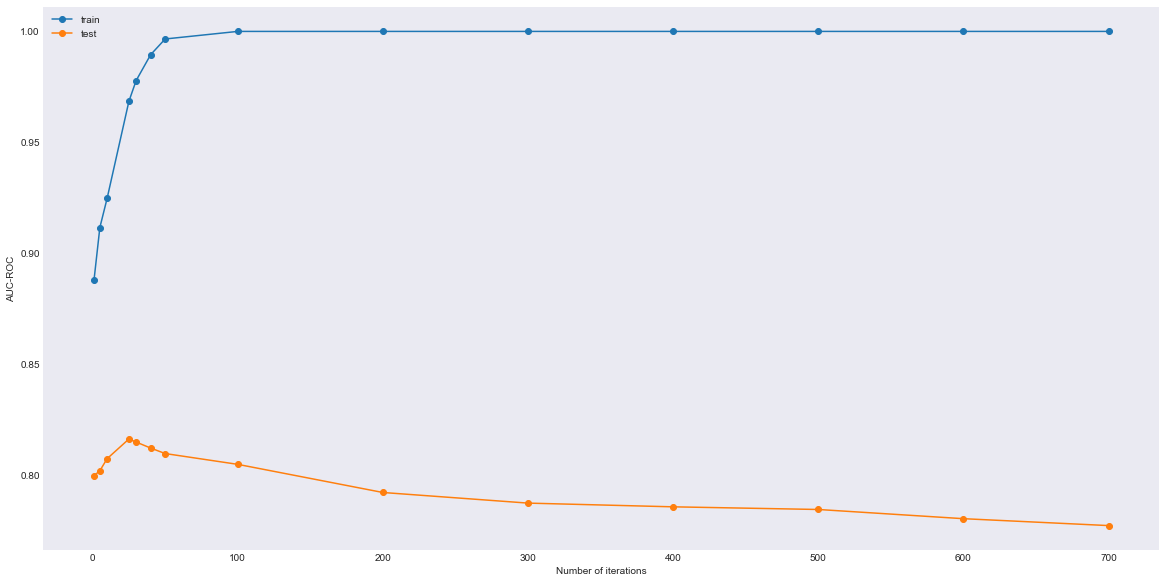

In [157]:
max_iter = [1, 5, 10, 25, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for m in max_iter:
    hgb = HistGradientBoostingClassifier(max_iter=m)
    hgb.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, hgb.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, hgb.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(20, 10))
plt.plot(max_iter, quals_train, marker='o', label='train')
plt.plot(max_iter, quals_test, marker='o', label='test')
plt.xlabel('Number of iterations')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

In [162]:
hist_gboost = HistGradientBoostingClassifier(max_iter=25)
hist_gboost.fit(X_train, y_train)
HGB_pred = hist_gboost.predict(X_test)

In [163]:
metrics(y_test, HGB_pred)

'Accuracy = 0.76, Precision = 0.74, Recall =  0.55'

In [164]:
grad_boost = GradientBoostingClassifier(n_estimators=50)
grad_boost.fit(X_train, y_train)
GB_pred = grad_boost.predict(X_test)

In [165]:
metrics(y_test, GB_pred)

'Accuracy = 0.76, Precision = 0.73, Recall =  0.56'

Метрики качества близкие с RandomForest ('Accuracy = 0.76, Precision = 0.75, Recall =  0.54'), между собой результаты тоже очень близки, но HistGradientBoostingClassifier лучше по скорости. 

**7. (1.5 балла)** Вспомните, что представляет из себя стэкинг моделей. Возьмите в качестве базовых моделей любой ансамблевый метод из тех, которые были использованы выше, и простой классификатор из уже вами изученных на курсе. В качестве мета-классификатора (модели, обученной на ответах) используйте лог-регресссию. Посчитайте метрики для мета-классификатора. Улучшилось ли качество?

В данном пункте мы можете как написать код для стекинга сами, так и использовать [`StackingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier).

В качестве базовых моделей я возьму RandomForestClassifier и SGDClassifier

In [284]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [309]:
np.random.seed(345)
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train, y_train, test_size=0.5)

In [310]:
model1 = RandomForestClassifier()
model2 = SGDClassifier()

In [311]:
model1.fit(X_train_, y_train_)
model2.fit(X_train_, y_train_)
y_pred_1 = model1.predict(X_valid_)
y_pred_2 = model2.predict(X_valid_)

In [312]:
y_tpred_1 = model1.predict(X_test)
y_tpred_2 = model2.predict(X_test)

In [313]:
stacked_pred = pd.DataFrame([y_pred_1, y_pred_2]).T
stacked_tpred = pd.DataFrame([y_tpred_1, y_tpred_2]).T

In [314]:
final_model = LogisticRegression()

In [315]:
final_model.fit(stacked_pred, y_valid_)
y_final_pred = final_model.predict(stacked_tpred)

In [316]:
metrics(y_test, y_final_pred)

'Accuracy = 0.77, Precision = 0.77, Recall =  0.56'

Относительно RandomForest по всем метрикам качество выросло. Модель не очень устойчива к изменениям в выборке (если поменять random.seed метрики качества меняются). Но я бы не доверила ни одной из выше рассмотренных моделей своё тестирование на диабет, потому что у всех низкий recall (то есть модель находит мало объектов с положительным классом), а цена ошибки False Negative высока.

Мне кажется низкое качество объясняется тем, что диагностировать диабет по этим данным однозначно нельзя и что его диагностируют через другие анализы (я даже загуглила и поняла, что сам по себе уровень глюкозы, который является самым важным согласно модели, не определяющий показатель), поэтому ни одна модель не выдала хороший результат.